In [11]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import librosa.display
import os

from sklearn.model_selection import train_test_split

In [12]:
import os

# List contents of the root directory of your Google Drive
drive_path = '/content/drive/MyDrive/'
print(os.listdir(drive_path))

['CS-21-488.jpg', 'IMG_4662.JPG', 'Saylor.pdf', 'Pool', 'File_000', 'Exam_mark_list_CS2021B_INTERNALTESTII.xls', 'Malapurm', 'Classroom', 'Jobin code.docx', 'jobin resume 2.pdf', 'IMG_4040.png', 'Passbook.JPG', 'ARTIST.gdoc', 'exp 6.gdoc', 'Iith fees .pdf', 'ERROR 404.pptx', 'JOBINJOY PONNAPPAL CERTIFICATES', 'IIIT ASSIGNMENT', 'system software qp jobinjoy Csb 5_compressed.pdf', 'IIT ASSIGNMENT 2', 'Colab Notebooks', 'iiit']


In [13]:
%cd /content/drive/MyDrive/iiit/AudioWAV

/content/drive/MyDrive/iiit/AudioWAV


In [14]:
path = '/content/drive/MyDrive/iiit/AudioWAV/'
audio_path = []
audio_emotion = []

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
# collects all the audio filename in the variable 'path'
directory_path = os.listdir(path)

In [17]:
for audio in directory_path:
    audio_path.append(path + audio)
    emotion = audio.split('_')
    if len(emotion) >= 3:
        if emotion[2] == 'SAD':
            audio_emotion.append("sad")
        elif emotion[2] == 'ANG':
            audio_emotion.append("angry")
        elif emotion[2] == 'DIS':
            audio_emotion.append("disgust")
        elif emotion[2] == 'NEU':
            audio_emotion.append("neutral")
        elif emotion[2] == 'HAP':
            audio_emotion.append("happy")
        elif emotion[2] == 'FEA':
            audio_emotion.append("fear")
        else:
            audio_emotion.append("unknown")
    else:
        audio_emotion.append("unknown")


In [19]:
emotion_dataset = pd.DataFrame(audio_emotion, columns=['Emotions'])
audio_path_dataset = pd.DataFrame(audio_path, columns=['Path'])
dataset = pd.concat([audio_path_dataset, emotion_dataset], axis= 1)
#print(len(dataset))
print(dataset.head())
# print(dataset['File Path'][55])

                                                Path Emotions
0  /content/drive/MyDrive/iiit/AudioWAV/1079_WSI_...  neutral
1  /content/drive/MyDrive/iiit/AudioWAV/1079_TSI_...    angry
2  /content/drive/MyDrive/iiit/AudioWAV/1079_TAI_...  disgust
3  /content/drive/MyDrive/iiit/AudioWAV/1079_TAI_...     fear
4  /content/drive/MyDrive/iiit/AudioWAV/1079_ITS_...    angry


VISUALIZATION

<Axes: title={'center': 'Emotion Count'}, xlabel='Emotions', ylabel='Count'>

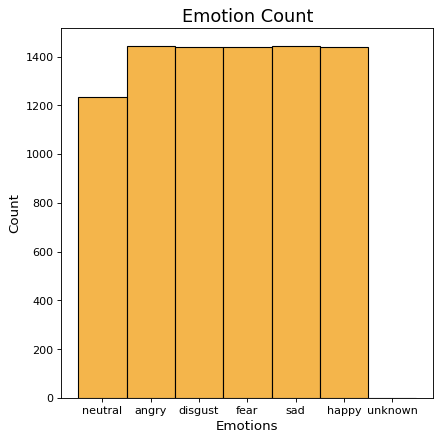

In [20]:
# counting audio categorized by emotions
plt.figure(figsize=(6,6), dpi=80)
plt.title("Emotion Count", size=16)
plt.xlabel('Emotions', size = 12)
plt.ylabel('Count', size = 12)
sns.histplot(dataset.Emotions, color='#F19C0E')
#plt.show()

In [21]:
emotion_sad = dataset[dataset['Emotions']=='sad']['Path']
print(type(emotion_sad))

<class 'pandas.core.series.Series'>


In [22]:
# Define the index you want to access
index = 2

# Check the size of the array
array_size = len(emotion_sad.values)

# Ensure that the index is within bounds
if 0 <= index < array_size:
    data_path = emotion_sad.values[index]
    data, sampling_rate = librosa.load(data_path)
    # Further processing with the loaded data
else:
    print("Index is out of bounds.")


In [23]:
#choosing a file to plot wave and spectogram
#print(emotion_sad.values[65])
data_path = emotion_sad.values[542]
data, sampling_rate = librosa.load(data_path)

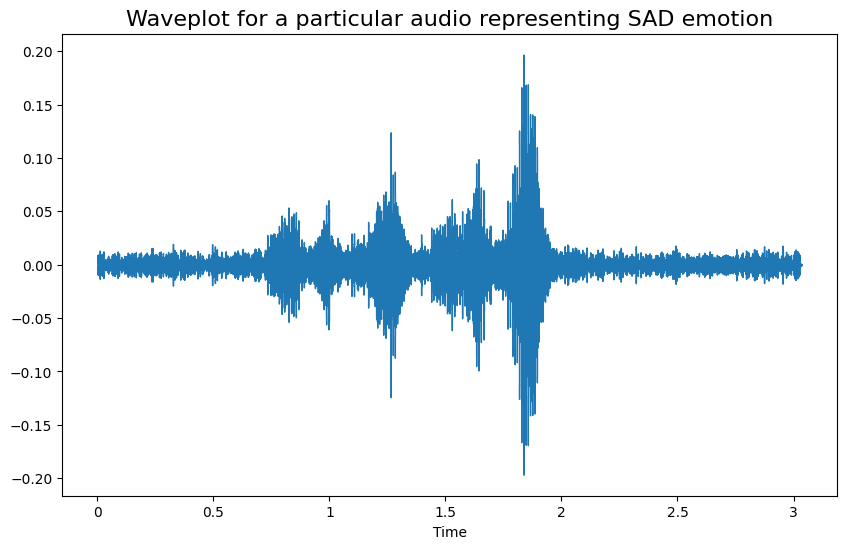

In [24]:
plt.figure(figsize=(10,6))
plt.title("Waveplot for a particular audio representing SAD emotion", size=16)
librosa.display.waveshow(data, sr=sampling_rate)
#plt.show()

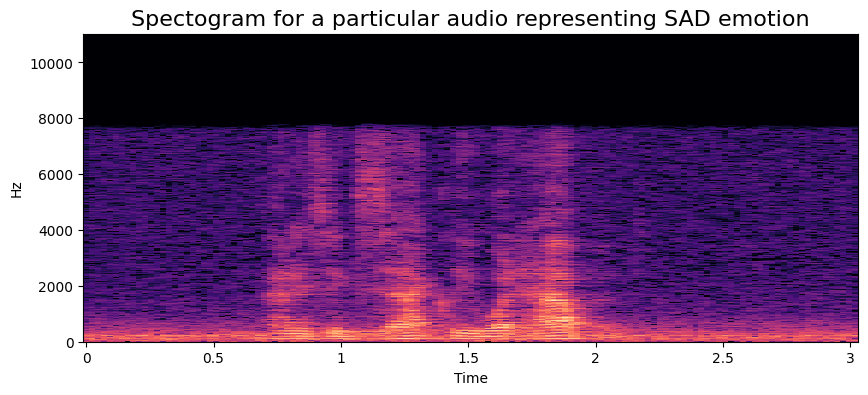

In [25]:
plt.figure(figsize=(10,4))
plt.title("Spectogram for a particular audio representing SAD emotion", size=16)
D = librosa.stft(data)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
librosa.display.specshow(S_db, sr = sampling_rate, x_axis='time', y_axis='hz')
#plt.show()

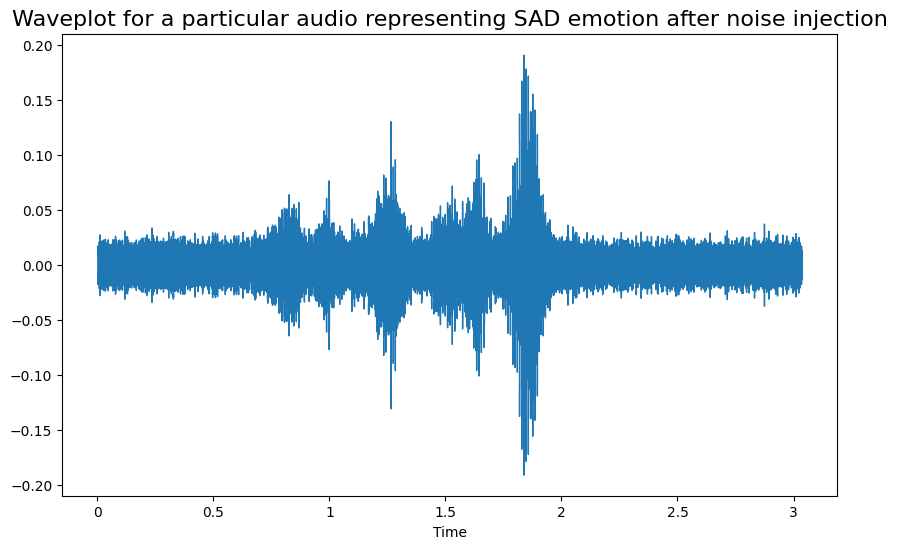

In [26]:
# for audio processing accuracy
# add noise to audio and check how the waveplot changes
# also the observing the change in audio quality

## Augmentation (Noise Injection)
noise_amp = 0.035*np.random.uniform()*np.amax(data)
audio_injected_data = data + noise_amp*np.random.normal(size=data.shape[0])

# waveplot view after noise injection:
plt.figure(figsize=(10,6))
plt.title("Waveplot for a particular audio representing SAD emotion after noise injection", size=16)
librosa.display.waveshow(audio_injected_data, sr=sampling_rate)
plt.show()

In [28]:
X, Y = [], []
print("Feature processing...")

for path, emo, index in zip(dataset.Path, dataset.Emotions, range(len(dataset))):
    # Skip non-audio files
    if not path.endswith('.wav'):
        continue

    try:
        value, sample = librosa.load(path)
        # noise injection
        noise_amp = 0.035 * np.random.uniform() * np.amax(value)
        value = value + noise_amp * np.random.normal(size=value.shape[0])
        # mfcc
        mfcc = librosa.feature.mfcc(y=value, sr= sample, n_mfcc=13, n_fft=200, hop_length=512)
        mfcc = np.ravel(mfcc.T)
        # mel
        mel = librosa.feature.melspectrogram(y=value, sr=sample, hop_length = 256, n_fft = 512, n_mels=64)
        mel = librosa.power_to_db(mel ** 2)
        mel = np.ravel(mel).T
        result = np.array([])
        result = np.hstack((result, mfcc, mel))
        result = np.array(result)
        X.append(result)
        Y.append(emo)
    except Exception as e:
        print(f"Error processing {path}: {e}")
        continue

print("Feature processing completed.")


Feature processing...
Feature processing completed.


In [29]:
# print(X)
# print(Y)
extracted_audio_df = pd.DataFrame(X)
extracted_audio_df["emotion_of_audio"] = Y
print(extracted_audio_df.shape)
print(extracted_audio_df.tail(10))
extracted_audio_df = extracted_audio_df.fillna(0)
#print(extracted_audio_df.isna().any())

(8441, 30457)
               0          1          2          3          4          5  \
8431 -708.580421 -63.043389   2.034151  15.816731  20.544642  -3.288991   
8432 -683.755360 -66.068260 -17.752023  24.529682  -0.246039   0.092238   
8433 -761.373641 -49.813953 -12.232750  29.327828  17.179133  -7.271524   
8434 -646.149063 -92.848246 -29.194979  33.705670  17.887068 -13.841144   
8435 -635.766000 -71.368300 -18.021664   8.686420  20.018091  -3.241487   
8436 -760.650671 -68.241726  -8.221149  22.505426  17.181800   9.025869   
8437 -756.400092 -23.107236 -12.185768  13.790873   9.421539  -9.668101   
8438 -769.990410 -29.486311   8.963860   3.412734  20.105112  16.992862   
8439 -759.570319 -60.710536 -13.410325  27.116287  33.314916 -15.612984   
8440 -697.657826 -56.126499   6.719032   7.417327 -13.427385  -5.624193   

              6          7          8          9  ...  30447  30448  30449  \
8431  -7.475417 -11.239968  -5.529021   3.023971  ...    NaN    NaN    NaN   
8432

In [30]:
# preparing to train
X = extracted_audio_df.drop(labels='emotion_of_audio', axis= 1)
Y = extracted_audio_df['emotion_of_audio']

x_train, x_test, y_train, y_test = train_test_split(np.array(X), Y, test_size=0.2)

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score


scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [32]:
mlp_model = MLPClassifier(activation='relu',
                         solver='sgd',
                         hidden_layer_sizes=100,
                         alpha=0.839903176695813,
                         batch_size=150,
                         learning_rate='adaptive',
                         max_iter=100000)
# Fit mlp model
mlp_model.fit(x_train,y_train)

MLPClassifier(alpha=0.839903176695813, batch_size=150, hidden_layer_sizes=100,
              learning_rate='adaptive', max_iter=100000, solver='sgd')

In [33]:
y_pred = mlp_model.predict(x_test)
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)

# the accuracy didn't turn out to be that good :(
print("\nModel:{}    Accuracy: {:.2f}%".
          format(type(mlp_model).__name__ , accuracy*100))


Model:MLPClassifier    Accuracy: 52.10%


In [34]:
# the prediction made by the model:
print("The Prediction Made By Model: ")
print("<<<===========================================>>>")
df = pd.DataFrame({'Actual': y_test, 'Predict': y_pred})
print(df.head())

The Prediction Made By Model: 
<<<===========================================>>>
       Actual  Predict
6986  neutral  neutral
4704    angry    angry
3670    happy    angry
1885  disgust  neutral
7659    happy    happy
